# 自动微分(automatic differentiation)
根据设计好的模型，系统会构建一个计算图（computational graph）， 来跟踪计算是哪些数据通过哪些操作组合起来产生输出。 自动微分使系统能够随后反向传播梯度。 这里，反向传播（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

In [1]:
import torch

In [2]:
x = torch.arange(4.0, requires_grad=True)
"""
x = torch.arange(4.0)
x.requires_grad_(True)
"""
x.grad

In [3]:
y = 2 * torch.dot(x, x)
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

>**Note**: 在默认情况下，PyTorch会累积梯度，需要清除之前的值

In [4]:
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## 分离计算
有时，我们希望将某些计算移动到记录的计算图之外。例如，假设$y$是作为$x$的函数计算的，而$z$则是作为$y$和$x$的函数计算的。想象一下，我们想计算$z$关于$x$的梯度，但由于某种原因，希望将$y$视为一个常数，并且只考虑到$x$在$y$被计算后发挥的作用。  
这里可以分离$y$来返回一个新变量$u$，该变量与$y$具有相同的值，但丢弃计算图中如何计算$y$的任何信息。换句话说，梯度不会向后流经$u$到$x$。因此，下面的反向传播函数计算$z=u\cdot x$关于$x$的偏导数，同时将$u$作为常数处理，而不是$z=x^3$关于$x$的偏导数。

In [5]:
x.grad.zero_()
y = x * x
u = y
print("u =", u)
z = u * x
z.sum().backward()
print("x.grad =", x.grad)
torch.equal(x.grad, 3 * x**2)

u = tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)
x.grad = tensor([ 0.,  3., 12., 27.])


True

In [6]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x
z.sum().backward()
print("x =", x)
print("y =", y)
print("u =", u)
print("z =", z)
print("x.grad =", x.grad)
print("u.grad =", u.grad)
torch.equal(x.grad, u)

x = tensor([0., 1., 2., 3.], requires_grad=True)
y = tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)
u = tensor([0., 1., 4., 9.])
z = tensor([ 0.,  1.,  8., 27.], grad_fn=<MulBackward0>)
x.grad = tensor([0., 1., 4., 9.])
u.grad = None


True

由于记录了$y$的计算结果，我们可以随后在$y$上调用反向传播，得到$y=x\cdot x$关于的$x$的导数，即$2\cdot x$。

In [7]:
x.grad.zero_()
y.sum().backward()
print("x.grad =", x.grad)
torch.equal(x.grad, 2 * x)

x.grad = tensor([0., 2., 4., 6.])


True

## 控制流的梯度计算¶
使用自动微分的一个好处是： 即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度。 在下面的代码中，while循环的迭代次数和if语句的结果都取决于输入a的值。

In [8]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c
x = torch.randn(size=(), requires_grad=True)
y = f(x)
y.backward()
print("x =", x)
print("y =", y)
print("x.grad =", x.grad)
torch.equal(x.grad, y / x)

x = tensor(-0.5619, requires_grad=True)
y = tensor(-115075.4375, grad_fn=<MulBackward0>)
x.grad = tensor(204800.)


True

# 线性回归

In [ ]:
import torch, random
from torch import nn
from torch.utils import data
from matplotlib import pyplot as plt

## 生成数据集

In [ ]:
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
features.size()

In [ ]:
labels.size()

In [ ]:
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

## 读取数据集

In [ ]:
batch_size = 10
data_iter = data.DataLoader(data.TensorDataset(features, labels), batch_size=batch_size, shuffle=True)
X, y = next(iter(data_iter))
X, y

## 定义模型
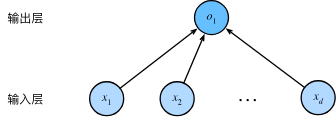
$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b = \mathbf{w}^\top \mathbf{x} + b,\ where\ \mathbf{x} \in \mathbb{R}^d, \mathbf{w} \in \mathbb{R}^d$$
$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,\ where\ \mathbf{X} \in \mathbb{R}^{n \times d}$$
$\mathbf{X}$的每一行是一个样本.
Sequential类将多个层串联在一起

In [ ]:
net = nn.Sequential(nn.Linear(2, 1))
net

## 参数初始化
1. 通过`net[0]`选择网络中的第一个图层
2. 使用`weight.data`和`bias.data`方法访问参数
3. 使用替换方法`normal_`和`fill_`来重写参数值

In [ ]:
net[0].weight.data

In [ ]:
net[0].bias.data

In [ ]:
net[0].weight.data.normal_(0, 0.01)

In [ ]:
net[0].bias.data.fill_(1)

* 验证模型和初始化参数

In [ ]:
y_hat = torch.matmul(X, net[0].weight.data.T) + net[0].bias.data
torch.equal(y_hat, net(X))

## 损失函数

In [ ]:
loss = nn.MSELoss()

* 验证损失函数值

In [ ]:
torch.sum((y_hat - y) ** 2)/y.numel()

In [ ]:
loss(net(X) ,y)

## 优化算法
待优化的参数可通过net.parameters()获得

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 训练

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    if isinstance(net, torch.nn.Module):
        net.train()         # 将模型设置为训练模式
    for X, y in data_iter:
        l = loss(net(X) ,y) # 计算损失函数loss（前向传播）
        trainer.zero_grad()
        l.backward()        # 进行反向传播来计算梯度
        trainer.step()      # 用优化器来更新模型参数
    
    if isinstance(net, torch.nn.Module):
        net.eval()          # 将模型设置为评估模式
    with torch.no_grad():
        l = loss(net(features), labels)
        print(f'epoch {epoch + 1}, loss {l:f}')

In [ ]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

# softmax回归

In [ ]:
import torch, torchvision, time
from torch import nn
from torchvision import transforms
from torch.utils import data
from matplotlib import pyplot as plt
from IPython import display

## 下载数据集

In [ ]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../../temp", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST( root="../../temp", train=False, transform=trans, download=True)

In [ ]:
print("训练集中的样本数量 =", len(mnist_train), ", 测试集中的样本数量", len(mnist_test))

In [ ]:
print("size of input of first sample =", mnist_train[0][0].shape)

In [ ]:
print("label of first sample =", mnist_train[0][1])

## 读取数据集

### 部分数据可视化

In [ ]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [ ]:
batch_size = 10
data_iter = data.DataLoader(mnist_train,
                            batch_size=batch_size,
                            shuffle=True,  # 随机打乱所有样本
                            num_workers=4) # 使用4个进程来读取数据                                                              

X, y = next(iter(data_iter))
show_images(X.reshape(batch_size, 28, 28), 2, int(batch_size/2), titles=get_fashion_mnist_labels(y));

### 多进程来读取数据对比

In [ ]:
start = time.time()
for X, y in data.DataLoader(mnist_train, batch_size=256):
    continue
end = time.time()
print(end - start, "sec")

In [ ]:
start = time.time()
for X, y in data.DataLoader(mnist_train, batch_size=256, num_workers=4):
    continue
end = time.time()
print(end - start, "sec")

### 训练和测试数据

In [ ]:
batch_size = 256
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=4)

## 定义模型
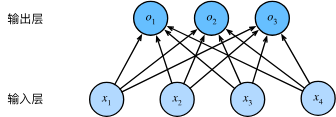

In [ ]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

In [ ]:
net

## 参数初始化

In [ ]:
for ii in range(len(net)):
    print(ii, type(net[ii]) == nn.Linear)

### [torch.nn.init.normal_(tensor, mean=0.0, std=1.0)](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.normal_)

In [ ]:
nn.init.normal_(net[1].weight, mean=0.0, std=0.01)

### 方法2

In [ ]:
net[1].weight.data.normal_(0.0, 0.01)

### 打印参数

In [ ]:
net[1].weight.data

## 损失函数

$n$样本数量, $d$单个样本的输入维度, $q$单个样本的输出维度, 即种类总数  
单个样本的loss:
$$\begin{split}\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}}) &= - \sum_{j=1}^q y_j \log \hat{y}_j \ (\because \hat{y}_j = \mathrm{softmax}(o_j) = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)})\\
&=  - \sum_{j=1}^q y_j \log \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} \\
&= \sum_{j=1}^q y_j \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j \ (\because \sum_{j=1}^q y_j = 1)\\
&= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j
\end{aligned}\end{split}$$
其导数:
$$ \frac{\partial  l(\mathbf{y}, \hat{\mathbf{y}})}{\partial {o_j}} = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(o_j) - y_j $$

$n$个样本的loss:
$$ \sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)})$$

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

### 验证

1. softmax 函数

In [ ]:
X2 = torch.normal(0, 1, (2, 5))
X2

In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

X_prob = softmax(X2)
X_prob

* 分步验证

In [ ]:
X_exp = torch.exp(X2)
X_exp

In [ ]:
partition = X_exp.sum(1, keepdim=True)
partition

In [ ]:
X_prob = X_exp / partition
X_prob

In [ ]:
X_prob.sum(1)

2. 验证模型和初始参数

In [ ]:
X, y = next(iter(data_iter))
Output = torch.matmul(X.reshape((-1, net[1].weight.data.T.shape[0])), net[1].weight.data.T) + net[1].bias.data
torch.equal(Output, net(X))

3. 验证loss<span id='id_loss'></span>

In [ ]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [ ]:
y_hat = softmax(Output)
print("y =", y)

In [ ]:
cross_entropy(y_hat, y)

In [ ]:
loss(net(X) ,y)

## 优化算法

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

## 训练

### 准备(累加器和动画)

In [ ]:
class Accumulator: # 累加器
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: self.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """Set the axes for matplotlib"""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()
        
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

### 定义分类正确函数
分类概率->分类结果

In [ ]:
def accuracy(y_hat, y):
    """计算分类正确次数"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

* 分步验证  
`y_hat` & `y` defined in [验证loss](#id_loss)

In [ ]:
if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
print("y_hat =", y_hat)
print("y =    ", y)
cmp = y_hat.type(y.dtype) == y # 由于等式运算符“==”对数据类型很敏感， 因此我们将y_hat的数据类型转换为与y的数据类型一致
print("cmp =  ", cmp)
print("分类正确的次数 =", float(cmp.type(y.dtype).sum()))

### 使用训练集，训练模型

In [ ]:
def train(net, train_iter, loss, optimizer):
    if isinstance(net, torch.nn.Module):
        net.train()                    # 将模型设置为训练模式
    metric = Accumulator(3)            # 累加器
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)             # 计算损失函数loss（前向传播）
        optimizer.zero_grad()
        l.mean().backward()            # 进行反向传播来计算梯度
        optimizer.step()               # 用优化器来更新模型参数

        metric.add(float(l.sum()),     # 训练损失总和
                   accuracy(y_hat, y), # 训练准确度总和
                   y.size(0))          # 样本数
    return metric[0] / metric[2], metric[1] / metric[2] # 返回训练集的平均损失和分类准确率

### 使用测试集，评估模型

In [ ]:
def evaluate(net, test_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()                          # 将模型设置为评估模式
    metric = Accumulator(2)                 # 累加器
    with torch.no_grad():
        for X, y in test_iter:
            metric.add(accuracy(net(X), y), # 当前分类正确次数
                       y.size(0))           # 当前样本数量

    return metric[0] / metric[1]           # 返回测试集的分类准确率

### 运行多个迭代周期。 在每个迭代周期结束时，利用test_iter访问到的测试数据集对模型进行评估。

In [ ]:
num_epochs = 10
animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], legend=["train loss", "train acc", "test acc"])

for epoch in range(num_epochs):
    train_metrics = train(net, train_iter, loss, optimizer) # 训练模型
    test_acc = evaluate(net, test_iter)                     # 评估模型
    print(epoch + 1, "train loss =", train_metrics[0], ", train acc =", train_metrics[1], ", test acc =", test_acc)
    animator.add(epoch + 1, train_metrics + (test_acc,))

train_loss, train_acc = train_metrics
assert train_loss < 0.5, train_loss
assert train_acc <= 1 and train_acc > 0.7, train_acc
assert test_acc <= 1 and test_acc > 0.7, test_acc

## 预测

In [ ]:
num_samples = 8

In [ ]:
X, y = next(iter(data.DataLoader(mnist_test, num_samples, shuffle=True)))

In [ ]:
labels = get_fashion_mnist_labels(y)

In [ ]:
outputs = get_fashion_mnist_labels(net(X).argmax(axis=1))

In [ ]:
titles = [true +'\n' + pred for true, pred in zip(labels, outputs)]
show_images(torch.squeeze(X), 1, num_samples, titles=titles)